In [ ]:
!pip install torch torchvision numpy pandas scikit-learn Flask


<ipython-input-3-27d61847ff82>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file_path, delim_whitespace=True, header=None, names=column_names)
<ipython-input-3-27d61847ff82>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file_path, delim_whitespace=True, header=None, names=column_names)


Epoch [1/50], Train Loss: 0.0318, Val Loss: 0.0186, Val RMSE: 0.1362, Val MAE: 0.1144
Epoch [2/50], Train Loss: 0.0146, Val Loss: 0.0137, Val RMSE: 0.1172, Val MAE: 0.0914
Epoch [3/50], Train Loss: 0.0135, Val Loss: 0.0119, Val RMSE: 0.1089, Val MAE: 0.0820
Epoch [4/50], Train Loss: 0.0121, Val Loss: 0.0107, Val RMSE: 0.1034, Val MAE: 0.0793
Epoch [5/50], Train Loss: 0.0099, Val Loss: 0.0093, Val RMSE: 0.0962, Val MAE: 0.0700
Epoch [6/50], Train Loss: 0.0096, Val Loss: 0.0084, Val RMSE: 0.0917, Val MAE: 0.0632
Epoch [7/50], Train Loss: 0.0091, Val Loss: 0.0085, Val RMSE: 0.0922, Val MAE: 0.0650
Epoch [8/50], Train Loss: 0.0088, Val Loss: 0.0086, Val RMSE: 0.0926, Val MAE: 0.0659
Epoch [9/50], Train Loss: 0.0087, Val Loss: 0.0083, Val RMSE: 0.0912, Val MAE: 0.0604
Epoch [10/50], Train Loss: 0.0086, Val Loss: 0.0090, Val RMSE: 0.0949, Val MAE: 0.0721
Epoch [11/50], Train Loss: 0.0080, Val Loss: 0.0083, Val RMSE: 0.0914, Val MAE: 0.0648
Epoch [12/50], Train Loss: 0.0078, Val Loss: 0.0079,

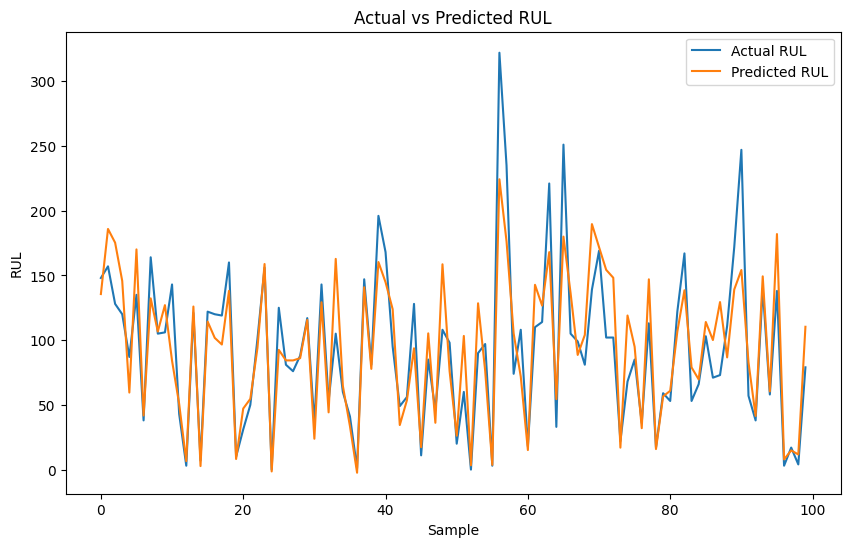

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the training data
train_file_path = 'train_FD001.txt'
test_file_path = 'test_FD001.txt'

# Column names based on the CMAPSS dataset structure
column_names = ['engine_id', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]

# Load data into pandas DataFrame
train_df = pd.read_csv(train_file_path, delim_whitespace=True, header=None, names=column_names)
test_df = pd.read_csv(test_file_path, delim_whitespace=True, header=None, names=column_names)

# Function to calculate Remaining Useful Life (RUL)
def calculate_rul(df):
    max_cycles = df.groupby('engine_id')['cycle'].max()
    df = df.merge(max_cycles, on='engine_id', suffixes=('', '_max'))
    df['RUL'] = df['cycle_max'] - df['cycle']
    return df

# Calculate RUL for the training data
train_df = calculate_rul(train_df)

# Drop the 'cycle_max' column as it’s no longer needed
train_df.drop('cycle_max', axis=1, inplace=True)

# Scale both sensor data and RUL values to the range [0, 1]
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler(feature_range=(0, 1))
train_df[sensor_columns] = scaler.fit_transform(train_df[sensor_columns])

max_rul = train_df['RUL'].max()  # Find max RUL for scaling
train_df['RUL'] = train_df['RUL'] / max_rul  # Scale RUL values

# Prepare sequences for LSTM model
def prepare_sequences(df, sequence_length):
    sequences = []
    targets = []
    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id]
        for i in range(len(engine_data) - sequence_length):
            seq = engine_data.iloc[i:i+sequence_length, 2:-1].values  # Sensor data
            rul = engine_data.iloc[i+sequence_length]['RUL']  # RUL at the end of sequence
            sequences.append(seq)
            targets.append(rul)
    return np.array(sequences), np.array(targets)

# Set sequence length and prepare data
sequence_length = 30
X_train, y_train = prepare_sequences(train_df, sequence_length)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch Dataset
class TurbofanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64
train_dataset = TurbofanDataset(X_train_tensor, y_train_tensor)
val_dataset = TurbofanDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model hyperparameters
input_size = X_train.shape[2]  # Number of sensor features
hidden_size = 256  # Increased hidden size
num_layers = 4     # Increased number of layers
output_size = 1

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Decreased learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduler

# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item() * X_batch.size(0)

            all_preds.extend(outputs.squeeze().cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))

    return val_loss, rmse, mae

# Training function with validation and scheduler
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss, val_rmse, val_mae = validate_model(model, val_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

        scheduler.step()  # Adjust learning rate after each epoch

# Train the model with validation and learning rate scheduling
train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50)

# Final evaluation function
def evaluate_model(model, val_loader, max_rul):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            all_preds.extend((outputs.squeeze().cpu().numpy()) * max_rul)  # Rescale predictions
            all_labels.extend((y_batch.cpu().numpy()) * max_rul)  # Rescale labels

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))
    print(f'Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}')

    # Plot actual vs predicted RUL
    plt.figure(figsize=(10, 6))
    plt.plot(all_labels[:100], label='Actual RUL')
    plt.plot(all_preds[:100], label='Predicted RUL')
    plt.xlabel('Sample')
    plt.ylabel('RUL')
    plt.title('Actual vs Predicted RUL')
    plt.legend()
    plt.show()

# Evaluate the model on validation data
evaluate_model(model, val_loader, max_rul)
